# CNN 304
Start with CNN 303 which demonstrated the use of Conv1D layers.

Clean up the code e.g. move onehot() to our tools library.

Since the CNN was overfitting, try again here but with no padding.

In [1]:
NC_FILENAME='ncRNA.tiny50.fasta'
PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='CNN304'  
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=5
SPLITS=1
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=16
KERNEL=3
NEURONS=16
DROP=0.25
ACT="tanh"

In [2]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    #embed_layer  = keras.layers.Embedding(
    #    input_dim=VOCABULARY_SIZE, output_dim=4, mask_zero=True)
    SHAPE=(1000,5)  # 1000 time steps, 5 features
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    #dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    #cnn.add(embed_layer)
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    #cnn.add(clayer4)
    #cnn.add(clayer5)
    #cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    #cnn.add(dlayer2)
    cnn.add(dlayer3)
    #cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [5]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

## to do:
Stop calling make_kmers() then onehot().
We're only using make_kmers convert ACGT to 1234.
Instead, write an RNA_to_onehot() function.

In [6]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
# print(X_train.shape)
print("First sequence as ints")
print(X_train[0])  
X_train=tools.onehot(X_train)
print("First sequence as onehot")
print(X_train[0])  

Load data from files.
Ready: train_set
Data reshape
First sequence as ints
[4 2 1 4 2 1 3 4 2 2 1 1 1 3 4 2 2 1 3 2 1 3 4 4 3 4 2 2 2 4 2 2 4 3 3 1 1
 4 2 2 3 4 4 3 3 2 4 4 3 2 2 4 2 2 3 3 2 1 4 4 4 4 4 3 3 2 2 2 4 4 3 2 2 4
 4 4 4 1 3 3 3 4 4 3 2 2 1 3 1 4 4 1 1 1 1 3 1 2 1 3 3 1 4 3 2 2 2 1 3 2 4
 1 3 4 4 4 3 1 1 4 4 4 4 1 3 1 4 1 1 1 2 1 1 2 3 1 1 4 1 1 4 4 4 2 3 4 1 3
 2 1 4 1 1 1 4 1 4 3 4 2 2 2 1 1 3 2 4 4 1 3 4 4 4 3 3 3 1 2 1 4 1 2 4 4 1
 4 3 2 4 1 1 1 1 1 1 2 1 4 4 1 4 4 3 3 4 4 3 4 4 4 1 4 2 4 3 1 3 1 4 4 2 1
 3 1 1 4 4 1 1 3 2 1 4 4 4 4 1 4 1 4 4 4 4 1 4 4 4 3 2 4 3 2 2 4 2 4 3 3 2
 2 1 2 2 2 4 1 2 4 2 4 2 4 4 2 2 4 1 1 2 1 2 4 2 4 2 4 2 2 2 4 2 4 2 2 2 1
 3 4 4 4 4 3 4 2 2 3 2 2 4 4 2 2 2 4 3 2 2 4 2 2 4 2 4 4 2 4 3 3 3 3 3 1 3
 4 4 1 3 1 4 2 3 1 3 4 4 3 4 1 1 2 1 1 3 1 1 2 1 4 3 2 2 1 2 4 3 4 2 4 2 3
 2 4 3 3 2 4 3 2 1 3 2 3 4 3 4 3 3 4 2 2 2 2 4 4 1 2 2 1 3 1 3 4 3 1 3 3 1
 4 3 2 3 1 1 3 1 3 1 1 3 3 4 3 3 2 4 3 4 2 4 3 2 1 1 1 2 2 1 3 3 1 1 3 1 3
 1 3 2 2 2 4 2 1 2 2 3 3 

In [7]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 16)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                128016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/5
3/3 [==============================] - 2s 519ms/step - loss: 0.7907 - accuracy: 0.4465 - val_loss: 0.3997 - val_accuracy: 0.8000
INFO:tensorflow:Assets written to: data/CNN304.cv.1.best/assets
Epoch 2/5
3/3 [==============================] - 0s 67ms/step - loss: 0.5198 - accuracy: 0.7678 - val_loss: 0.4107 - val_accuracy: 0.8000
Epoch 3/5
3/3 [==============================] - 0s 70ms/step - loss: 0.5310 - accuracy: 0.7199 - val_loss: 0.3436 - val_accuracy: 0.9000
INFO:tensorflow:Assets written to: data/CNN304.cv.1.best/assets
Epoch 4/5
3/3 [==============================] - 0s 60ms/step - loss: 0.4687 - accuracy: 0.7766 - val_loss: 0.2824 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: data/CNN304.cv.1.best/assets
Epoch 5/5
3/3 [==============================] - 0s 69ms/step - loss: 0.3779 - accuracy: 0.8102 - val_loss: 0.2711 - val_accuracy: 0.9000
Fold 1, 5 epochs, 6 sec


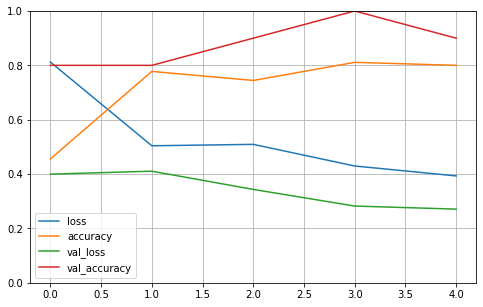

accuracy: 100.00%

1-way Cross Validation mean 100.00% (+/- 0.00%)
Done


In [8]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")